# Audio Input Debug

Check microphone input levels.

In [1]:
import sounddevice as sd
import numpy as np

# List available devices
print(sd.query_devices())

   0 USB Device 0x46d:0x825: Audio (hw:0,0), ALSA (1 in, 0 out)
   1 Samson Q2U Microphone: USB Audio (hw:1,0), ALSA (2 in, 2 out)
   2 HDA Intel PCH: ALC256 Analog (hw:2,0), ALSA (2 in, 2 out)
   3 HDA Intel PCH: C24M2020D (hw:2,3), ALSA (0 in, 2 out)
   4 HDA Intel PCH: C24M2020D (hw:2,7), ALSA (0 in, 2 out)
   5 HDA Intel PCH: HDMI 2 (hw:2,8), ALSA (0 in, 8 out)
   6 HDA Intel PCH: HDMI 3 (hw:2,9), ALSA (0 in, 8 out)
   7 ULIX Earphones: USB Audio (hw:3,0), ALSA (1 in, 2 out)
   8 sysdefault, ALSA (128 in, 0 out)
   9 spdif, ALSA (1 in, 0 out)
  10 pipewire, ALSA (64 in, 64 out)
* 11 default, ALSA (64 in, 64 out)


In [2]:
# Configuration
DEVICE = 1  # Samson Q2U Microphone
SAMPLE_RATE = 16000
DURATION = 2.0  # seconds

print(f"Recording from device {DEVICE} for {DURATION} seconds...")
print(f"Device info: {sd.query_devices(DEVICE)}")

Recording from device 1 for 2.0 seconds...
Device info: {'name': 'Samson Q2U Microphone: USB Audio (hw:1,0)', 'index': 1, 'hostapi': 0, 'max_input_channels': 2, 'max_output_channels': 2, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': 0.008684807256235827, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': 0.034829931972789115, 'default_samplerate': 44100.0}


In [3]:
# Record audio
num_samples = int(SAMPLE_RATE * DURATION)
recording = sd.rec(
    num_samples,
    samplerate=SAMPLE_RATE,
    channels=1,
    dtype=np.int16,
    device=DEVICE,
)
sd.wait()
print(f"Recorded {len(recording)} samples")

Recorded 32000 samples


In [ ]:
# Analyze volume
audio_data = recording.flatten()

peak = int(np.max(np.abs(audio_data)))
rms = np.sqrt(np.mean(audio_data.astype(np.float64) ** 2))

print(f"Peak amplitude: {peak} (max possible: 32767)")
print(f"RMS amplitude: {rms:.1f}")
print(f"Peak as % of max: {100 * peak / 32767:.1f}%")

if peak < 100:
    print("\n⚠️  Very low signal - microphone may not be working")
elif peak < 1000:
    print("\n⚠️  Low signal - check microphone gain")
else:
    print("\n✓ Signal detected")

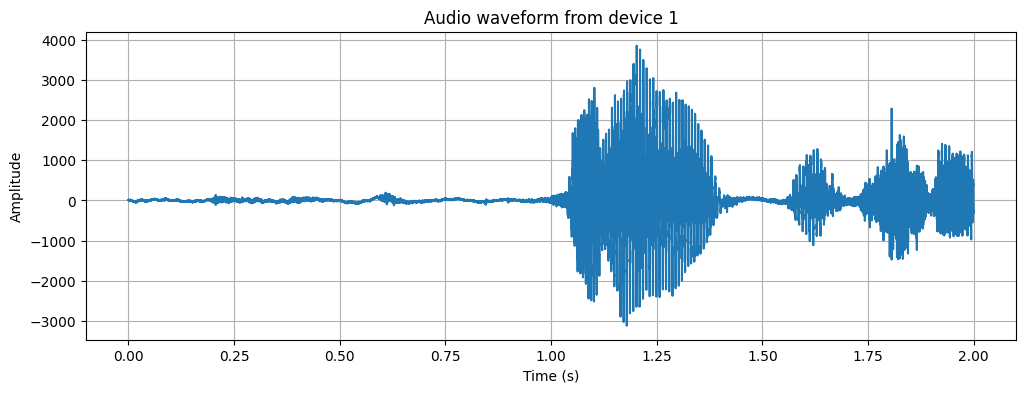

In [6]:
# Show waveform
import matplotlib.pyplot as plt

time = np.arange(len(audio_data)) / SAMPLE_RATE
plt.figure(figsize=(12, 4))
plt.plot(time, audio_data)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Audio waveform from device {DEVICE}")
plt.grid(True)
plt.show()

In [7]:
# Test the transcriber service
import io
import wave
import httpx

# Convert recording to WAV bytes
buffer = io.BytesIO()
with wave.open(buffer, 'wb') as wav_file:
    wav_file.setnchannels(1)
    wav_file.setsampwidth(2)
    wav_file.setframerate(SAMPLE_RATE)
    wav_file.writeframes(recording.tobytes())

wav_bytes = buffer.getvalue()
print(f"WAV size: {len(wav_bytes)} bytes")

# Send to transcriber
TRANSCRIBER_URL = "http://localhost:8765"
try:
    response = httpx.post(
        f"{TRANSCRIBER_URL}/api/transcribe",
        content=wav_bytes,
        headers={"Content-Type": "audio/wav"},
        timeout=30.0,
    )
    response.raise_for_status()
    result = response.json()
    print(f"Transcription: '{result['text']}'")
except httpx.ConnectError:
    print(f"⚠️  Cannot connect to transcriber at {TRANSCRIBER_URL}")
    print("   Is the transcriber service running?")
except Exception as e:
    print(f"Error: {e}")

WAV size: 64044 bytes
Transcription: 'Hello, let's see.'
